In this notebook I search for the best classifier and its parameters for tweets multi-class classifications based on authorship attributes.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
# from pandas import Series,DataFrame
import numpy as np
import os
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
%matplotlib inline
import itertools

In [2]:
# Set the path to the folder containing CSV files
folder_path = 'tweets/'
os.listdir(folder_path)
            
            

['.ipynb_checkpoints',
 '10460KDNuggetsTweets.csv',
 'AdamSavageTweets.csv',
 'AllTweets.csv',
 'BarackObama.csv',
 'DonaldTrump2014-01-01To2016-10-14Tweets.csv',
 'DonaldTrumpTweets.csv',
 'FiveThirtyEightTweets.csv',
 'HillaryClinton2014-01-01To2016-10-14Tweets.csv',
 'HillaryClintonTweets.csv',
 'KimKardashianTweets.csv',
 'NeildeGrasseTysonTweets.csv',
 'RichardDawkins.csv',
 'ScottKelly.csv']

In [3]:
# Get a list of all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Create an empty list to store DataFrames
dfs = []

# Loop through each CSV file and read it into a DataFrame
for csv_file in csv_files:
    csv_file_path = os.path.join(folder_path, csv_file)
    df = pd.read_csv(csv_file_path)
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)

# Print the combined DataFrame
combined_df

,Unnamed: 0,date,id,link,retweet,text,author,Unnamed: 0.1
0,0,Oct 4,783396985093193728,/missyscheng/status/783396985093193728,False,#DataScience Basics: #DataMining vs. #Statisti...,various,NaN
1,1,Oct 4,783381842024103936,/EXASOLAG/status/783381842024103936,False,How to Become a #Data Scientist – Part 1: http...,various,NaN
2,2,Oct 4,783433625723252736,/TarasNovak/status/783433625723252736,False,@jesterxl @kdnuggets or just go with @tableau :),various,NaN
3,3,Oct 4,783428740453982208,/kdnuggets/status/783428740453982208,False,#Boston U. Online MS in Applied #Business #Ana...,various,NaN
4,4,1h1 hour ago,787052623291641856,/kdnuggets/status/787052623291641856,False,#ICYMI Still Searching for ROI in #BigData Ana...,various,NaN
...,...,...,...,...,...,...,...,...
173030,1214,24 Aug 2009,3506949420,/StationCDRKelly/status/3506949420,False,@karen4jazz thanks!,ScottKelly,NaN
173031,1215,23 Aug 2009,3505850138,/StationCDRKelly/status/3505850138,False,The HARDEST thing about this ISS training is h...,ScottKelly,NaN
173032,1216,23 Aug 2009,3500803828,/StationCDRKelly/status/3500803828,False,Eating breakfast at the Okura Frontier Hotel i...,ScottKelly,NaN
173033,1217,23 Aug 2009,3488056654,/StationCDRKelly/status/3488056654,False,I think you will find the comparison (and cont...,ScottKelly,NaN


In [4]:
df = combined_df.copy()
df = df.dropna()
print(df.isna().sum())

Unnamed: 0      0
date            0
id              0
link            0
retweet         0
text            0
author          0
Unnamed: 0.1    0
dtype: int64


In [5]:
# assuming the combined_df has columns 'text' and 'author'
grouped_df = df.groupby('author')

# count the number of texts per author
author_counts = grouped_df.size()

# # calculate the min, max, and average number of words per author
author_stats = grouped_df.agg({'text': [lambda x: x.str.split().apply(len).min(),
                                        lambda x: x.str.split().apply(len).max(),
                                        lambda x: x.str.split().apply(len).mean()]})

author_stats.columns = ['min_words', 'max_words', 'avg_words']

result_df = pd.concat([author_counts, author_stats], axis=1)

print(result_df)

# # Group the DataFrame by author and calculate the average number of words in each text
# grouped_data = df.groupby('author')['text'].agg(lambda x: x.apply(lambda x: len(x.split(' '))).mean())
# grouped_data

                     0  min_words  max_words  avg_words
author                                                 
AdamSavage        4872          1         31  15.374179
BarackObama       6896          1         33  16.649797
DonaldTrump      17216          1         32  18.031715
FiveThirtyEight   9761          2         30  13.261141
HillaryClinton    3356          1         29  16.934148
KimKardashian    10688          1         34  13.154004
NASA             15910          2         30  16.957825
RichardDawkins    5839          1         32  19.021579
ScottKelly        1219          1         30  14.963905
deGrasseTyson     2428          1         40  19.013180
various          10440          2         29  12.684291


In [6]:
pd.DataFrame(df.groupby('author').size().rename('counts')).sort_values('counts', ascending=False)

,counts
author,
DonaldTrump,17216
NASA,15910
KimKardashian,10688
various,10440
FiveThirtyEight,9761
BarackObama,6896
RichardDawkins,5839
AdamSavage,4872
HillaryClinton,3356


## Pre-processing

In [7]:
# remove web links from texts

# df.loc[:, 'text'] = df.loc[:, 'text'].apply(lambda x: re.sub(r'(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)', '', x))
# df.iloc[1,:]['text']
url_regex = r'(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)'
rt_regex = r'RT\b'
tag_regex = r'#\S+'

# Define the replacement strings for URLs, re-tweets, and hashtags
url_replace = 'URL'
rt_replace = 'RT'
tag_replace = 'TAG'

# Define a function to normalize the text
def normalize_text(text):
    # Normalize URLs
    text = re.sub(url_regex, url_replace, text)
    
    # Normalize re-tweets
    text = re.sub(rt_regex, rt_replace, text)
    
    # Normalize hashtags
    text = re.sub(tag_regex, tag_replace, text)
    
    return text

# Apply the normalization function to the text column
df.loc[:, 'text'] =df.loc[:, 'text'].apply(normalize_text)

In [8]:


# Define the tokenizer
tokenizer = nltk.RegexpTokenizer(r'\w+')

# Define the stemmer
stemmer = PorterStemmer()

# Define the stop words
stop_words = set(stopwords.words('english'))

# Define a function to preprocess the text
def preprocess_text(text):
    # Tokenize the text
    # text = text['text']
    tokens = tokenizer.tokenize(text)
    
    # Remove stop words
    tokens = [word for word in tokens if not word in stop_words]
    
    # Stem the tokens
    # tokens = [stemmer.stem(token) for token in filtered_tokens]
    
    # Join the tokens back into a string
    preprocessed_text = ' '.join(tokens)
    # text['text'] = preprocessed_text
    # print(text)
    return text

# Apply the preprocessing function to the text column
# df['text'] = df.apply(preprocess_text, axis=1)
df.loc[:,'text'] = df.loc[:,'text'].apply(preprocess_text)

In [9]:

# Compute the mean and standard deviation of the text lengths
mean_length = np.mean(df['text'].apply(lambda x: len(x.split(' '))))
sd_length = np.std(df['text'].apply(lambda x: len(x.split(' '))))

# Define the threshold for filtering based on length
threshold = mean_length - 1.65 * sd_length
print(threshold)
# Filter the DataFrame based on the text length
df = df[df['text'].apply(lambda x: len(x.split(' '))) >= threshold]
pd.DataFrame(df.groupby('author').size().rename('counts')).sort_values('counts', ascending=False)

6.06770402015181


,counts
author,
DonaldTrump,16562
NASA,15712
various,10140
FiveThirtyEight,9170
KimKardashian,7981
BarackObama,6511
RichardDawkins,5755
AdamSavage,4251
HillaryClinton,3133


In [7]:
import random
from sklearn.model_selection import train_test_split
#1000 random sample rows for each author
df_new=pd.DataFrame()
twts_train=pd.DataFrame()
twts_test=pd.DataFrame()
author_train=pd.DataFrame()
author_test=pd.DataFrame()
for a in df.author.unique():
    rows = random.sample(list(df[df['author']==a].index), 1000)
    df_temp = df.loc[rows]
    # df_new=df_new.append(df_temp,ignore_index=True)   
    df_new = pd.concat([df_new, df_temp], ignore_index=True)
    X_train, X_test, Y_train, Y_test = train_test_split(df_temp.loc[:,['text']], df_temp.loc[:,['author']], test_size=0.5, random_state=42)
    twts_train=twts_train.append(X_train, verify_integrity=False)
    twts_test=twts_test.append(X_test, verify_integrity=False)
    author_train=author_train.append(Y_train, verify_integrity=False)
    author_test=author_test.append(Y_test, verify_integrity=False)

Train set:

In [8]:
print (len(twts_train),len(author_train))

5500 5500


Test set:

In [9]:
print(len(twts_test),len(author_test))

5500 5500


In [10]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
def text_process(text):
    """
    Takes in a string of text, then performs the following:
    1. Tokenizes and removes punctuation
    3. Stems
    4. Returns a list of the cleaned text
    """

    # tokenizing
    tokenizer = RegexpTokenizer(r'\w+')
    text_processed=tokenizer.tokenize(text)
    
    
    # steming
    porter_stemmer = PorterStemmer()
    
    text_processed = [porter_stemmer.stem(word) for word in text_processed]
    

    return text_processed

In [11]:
ScoreSummaryByModel = list()

In [27]:
def PredictionEvaluation(author_test_b,author_predicted_b,target_names,comment):
    Accuracy=accuracy_score(author_test_b,author_predicted_b)
    #print (Accuracy)
    Recall=recall_score(author_test_b, author_predicted_b, labels=[0,1,2,3], average='macro')
    #print (Recall)
    Precision=precision_score(author_test_b, author_predicted_b, labels=[0,1,2,3], average='macro')
    #print (Precision)
    F1=f1_score(author_test_b, author_predicted_b, labels=[0,1,2,3], average='macro')
    #print (F1)
    confusion_mat = confusion_matrix(author_test_b.argmax(axis=1), author_predicted_b.argmax(axis=1))
    
    ScoreSummaryByModel.append([Accuracy,Recall,Precision,F1,comment])
    print('Accuracy', Accuracy)
    print(classification_report(author_test_b, author_predicted_b, target_names=target_names))
    # print(confusion_mat)
    plot_confusion_matrix(confusion_mat, target_names)
    
    FP = confusion_mat.sum(axis=0) - np.diag(confusion_mat)  
    FN = confusion_mat.sum(axis=1) - np.diag(confusion_mat)
    TP = np.diag(confusion_mat)
    TN = confusion_mat.sum() - (FP + FN + TP)
    TPR = TP/(TP+FN)
    # print(TPR)
    print(TP) 
    print(FP)        

In [13]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('plot.png', dpi=300)

In [14]:
ScoreSummaryByModelParams=list()

In [15]:
def ModelParamsEvaluation (f_union,model,params,comment):
    pipeline = Pipeline([
    # Extract the text & text_coded
    # Use FeatureUnion to combine the features from different vectorizers
    ('union', f_union),
    # Use a  classifier on the combined features
    ('clf', model)
    ])
    grid_search = GridSearchCV(estimator=pipeline, param_grid=params, verbose=1)
    grid_search.fit(twts_train['text'], author_train['author'])
    author_predicted = grid_search.predict(twts_test['text'])
    lb = LabelBinarizer()
    author_test_b = lb.fit_transform(author_test['author'])
    author_predicted_b  = lb.fit_transform(author_predicted)
    #best score
    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    author_names=grid_search.best_estimator_.named_steps['clf'].classes_

    for param_name in sorted(params.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        ScoreSummaryByModelParams.append([comment,grid_search.best_score_,"\t%s: %r" % (param_name, best_parameters[param_name])]) 
    return (author_predicted,author_predicted_b,author_test_b,author_names)

In [16]:
f2_union=FeatureUnion(
        transformer_list=[
            # Pipeline for pulling char features  from the text
            ('char', Pipeline([
                ('tfidf',     TfidfVectorizer(analyzer='char',ngram_range=(1, 5))),
            ])),
            # Pipeline for pulling stememd word features from the text
            # ('text', Pipeline([
            #     ('tfidf',    TfidfVectorizer(analyzer='word',tokenizer= text_process,ngram_range=(1, 1))),
            # ])),        

        ],

    )

In [17]:
from sklearn.svm import LinearSVC
#LinearSVC
p = {'clf__C': (1,0.1,0.01,0.001,0.0001)}
(author_predicted,author_predicted_b, author_test_b,author_names)=ModelParamsEvaluation(f2_union,LinearSVC(),p,'LinearSVC')

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best score: 0.861
Best parameters set:
	clf__C: 1


Accuracy 0.8738181818181818
                 precision    recall  f1-score   support

     AdamSavage       0.75      0.83      0.79       450
    BarackObama       0.83      0.94      0.88       443
    DonaldTrump       0.83      0.82      0.83       509
FiveThirtyEight       0.98      1.00      0.99       490
 HillaryClinton       0.89      0.78      0.83       567
  KimKardashian       0.88      0.90      0.89       490
           NASA       0.92      0.93      0.92       493
 RichardDawkins       0.83      0.81      0.82       510
     ScottKelly       0.86      0.88      0.87       490
  deGrasseTyson       0.85      0.76      0.80       560
        various       1.00      1.00      1.00       498

      micro avg       0.87      0.87      0.87      5500
      macro avg       0.87      0.88      0.87      5500
   weighted avg       0.87      0.87      0.87      5500
    samples avg       0.87      0.87      0.87      5500

[374 415 417 490 445 440 458 414 432 423 498]
[126  85  8

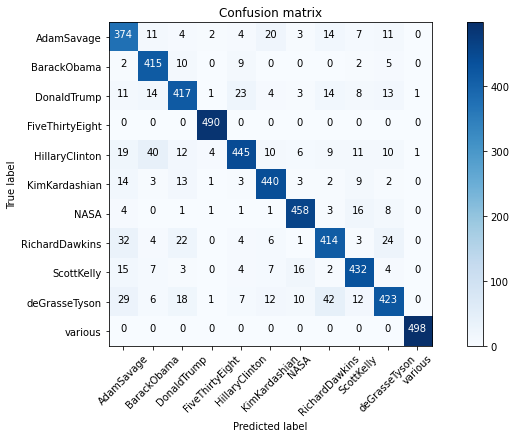

In [28]:
PredictionEvaluation(author_predicted_b, author_test_b,author_names,'LinearSVC')

In [63]:
d = twts_test[:500]
# author_predicted_b
# d[(author_test_b[:500] == author_predicted_b[:500]).all(axis=1)]
# (author_test_b == author_predicted_b)[3]
# author_test_b[:500].shape
d

,text
17311,Did you miss it? @BoeingDefense revealed the n...
30018,The shuttle’s readiness review concluded today...
26539,Pretty picture of the Global Hawk prepping for...
19322,"Searching for the #SuperBloodMoon, but clouds ..."
24803,RT @MarshaCollier: Amazing photo from @Stefmar...
...,...
16408,During @StationCDRKelly’s #YearInSpace he rack...
18076,Congrats @BlueOrigin on New Shepard spacecraft...
27726,NASA Launches Open Government online with Data...
24778,99% of the required J-2X engine components hav...
